# Supply analysis of Data&Co

 the DataCo company, dataset customer segmentation analysis was performed in this project which helps the company to better understand its customers and target them to increase customer responsiveness and the company's revenue. With a lot of options available to analyze data, it is very difficult to decide which method and machine learning model to use since the performance of the model vary on the parameters available in the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

import datetime as dt
import calendar,warnings,itertools,matplotlib,keras,shutil
import tensorflow as tf
import statsmodels.api as sm
from datetime import datetime
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict
from sklearn import svm,metrics,tree,preprocessing,linear_model
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge,LinearRegression,LogisticRegression,ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier, GradientBoostingRegressor,BaggingClassifier,ExtraTreesClassifier
from sklearn.metrics import accuracy_score,mean_squared_error,recall_score,confusion_matrix,f1_score,roc_curve, auc
from sklearn.datasets import load_iris,make_regression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.kernel_ridge import KernelRidge
from keras import Sequential
from keras.layers import Dense
from IPython.core import display as ICD

#Hiding the warnings
warnings.filterwarnings('ignore') 

In [2]:
dataset=pd.read_csv("DataCoSupplyChainDataset.csv",header= 0,encoding= 'unicode_escape')
dataset.head(5)

,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2/3/2018 22:56,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/18/2018 12:27,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/17/2018 12:06,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/16/2018 11:45,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,1/15/2018 11:24,Standard Class


# Data Cleaning

In [3]:


dataset.shape



(180519, 53)

In [4]:


dataset.apply(lambda x: sum(x.isnull())) #Checking missing values



Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0




 since there is a chance different customers might have the same first name or same last name a new column with ‘customer full name’ is created to avoid any ambiguities.


In [5]:


# Adding first name and last name together to create new column
dataset['Customer Full Name'] = dataset['Customer Fname'].astype(str)+dataset['Customer Lname'].astype(str)



To make it easier for analysis some unimportant columns are dropped

In [6]:


data=dataset.drop(['Customer Email','Product Status','Customer Password','Customer Street','Customer Fname','Customer Lname',
           'Latitude','Longitude','Product Description','Product Image','Order Zipcode','shipping date (DateOrders)'],axis=1)
data.shape



(180519, 42)

There are 3 missing values in Customer Zipcode column. Since the missing values are just zip codes which are not very important these are replaced with zero before proceeding with data analysis.

In [7]:


data['Customer Zipcode']=data['Customer Zipcode'].fillna(0)#Filling NaN columns with zero



# Data Visualisation

to find important parameters, data correlation is performed

<AxesSubplot:>

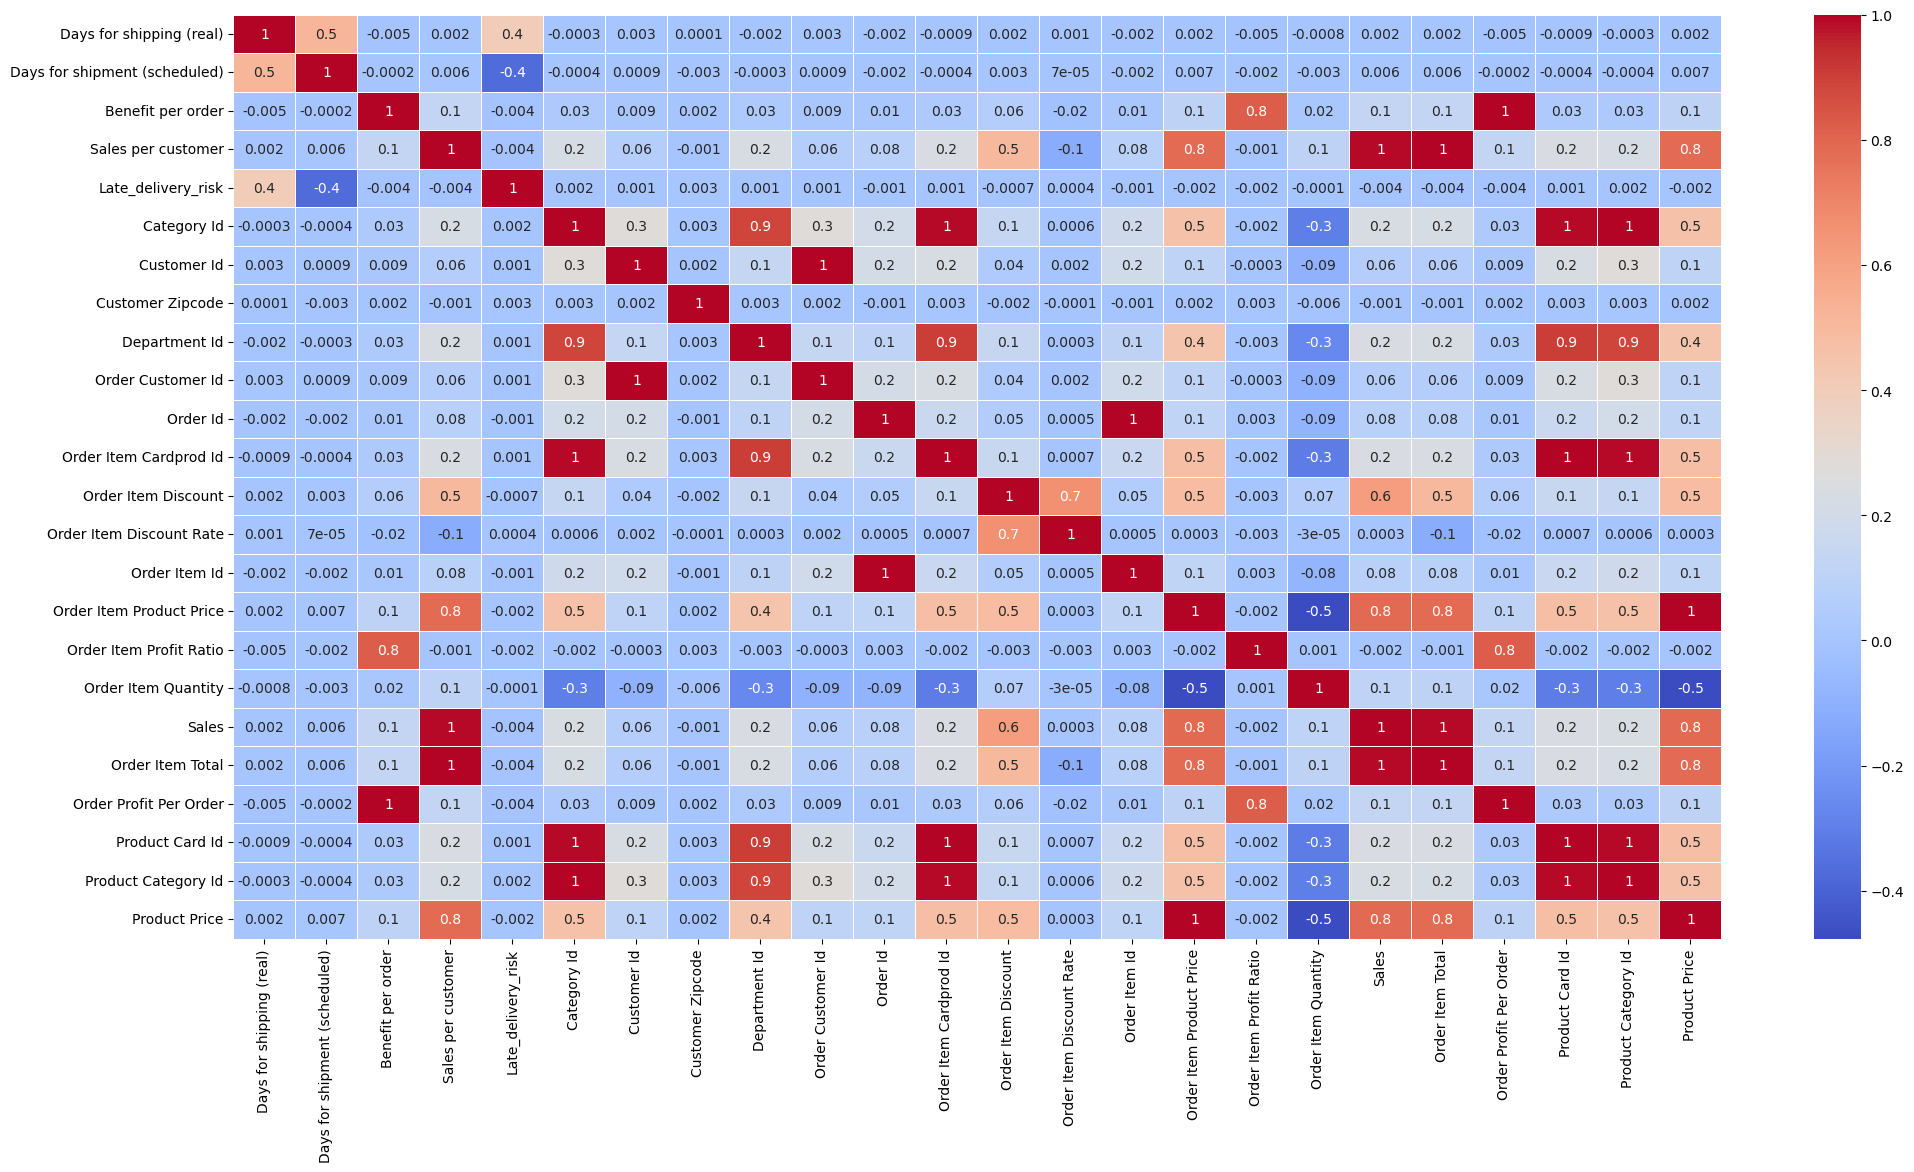

In [8]:


fig, ax = plt.subplots(figsize=(24,12))         # figsize
sns.heatmap(data.corr(),annot=True,linewidths=.5,fmt='.1g',cmap= 'coolwarm') # Heatmap for correlation matrix



We can observe that product price price has high correlation with Sales,Order Item Total.

As the data which is being used for analysis is related to Supply chain, it makes sense to find which REGION has most sales? 

<AxesSubplot:title={'center':'Total sales for all regions'}, xlabel='Order Region'>

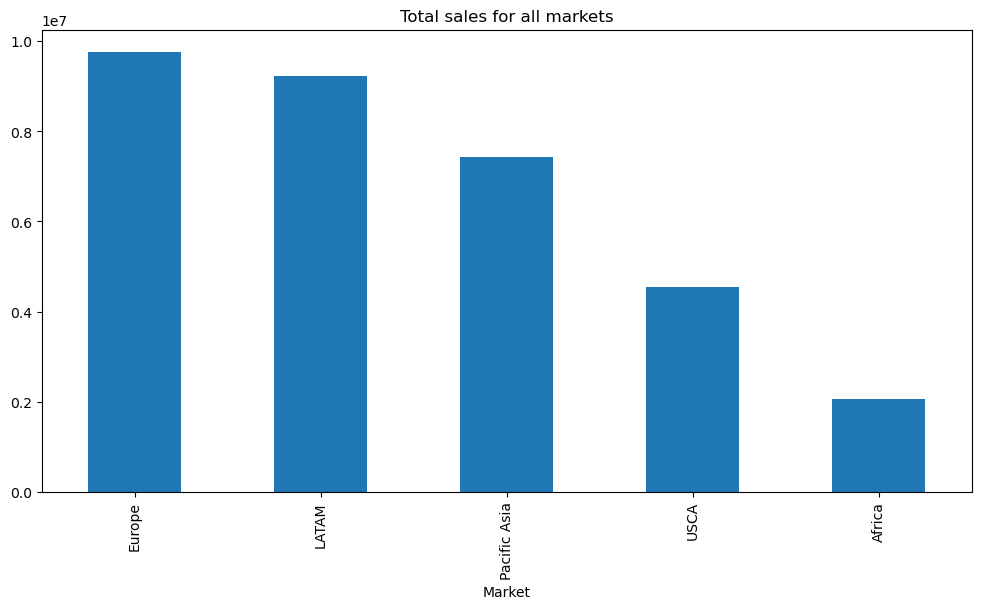

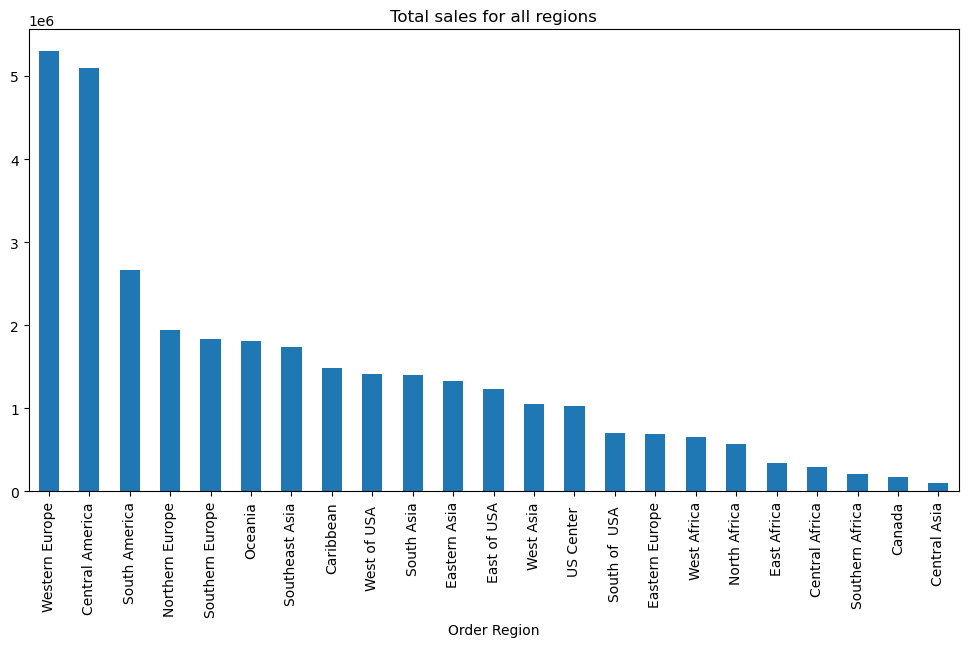

In [9]:
market = data.groupby('Market') #Grouping by market
region = data.groupby('Order Region')
plt.figure(1)
market['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales for all markets")
plt.figure(2)
region['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales for all regions")



It could be seen from the graph that European market has the most number of sales whereas Africa has the least.In these markets western europe regions and central america recorded highest sales.

Which CATEGORY of products has highest sales?


<AxesSubplot:title={'center':'Average price'}, xlabel='Category Name'>

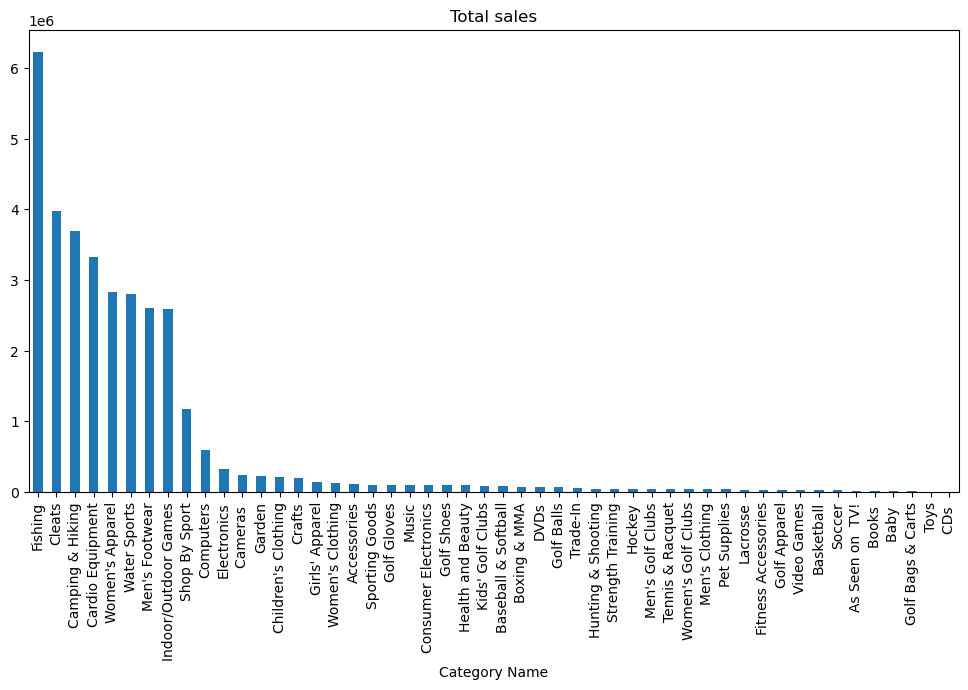

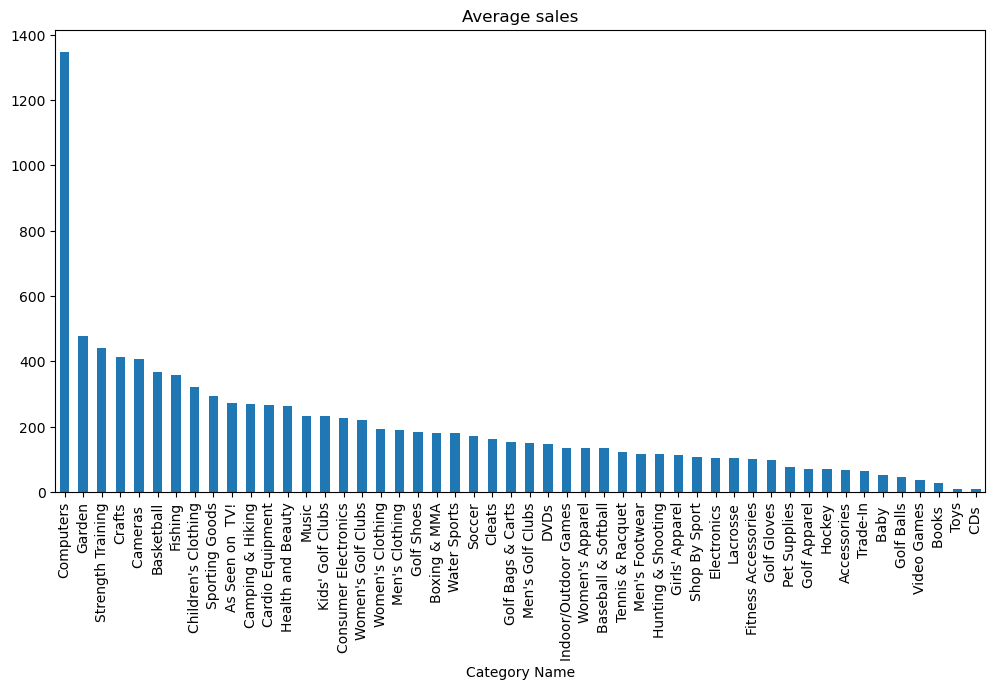

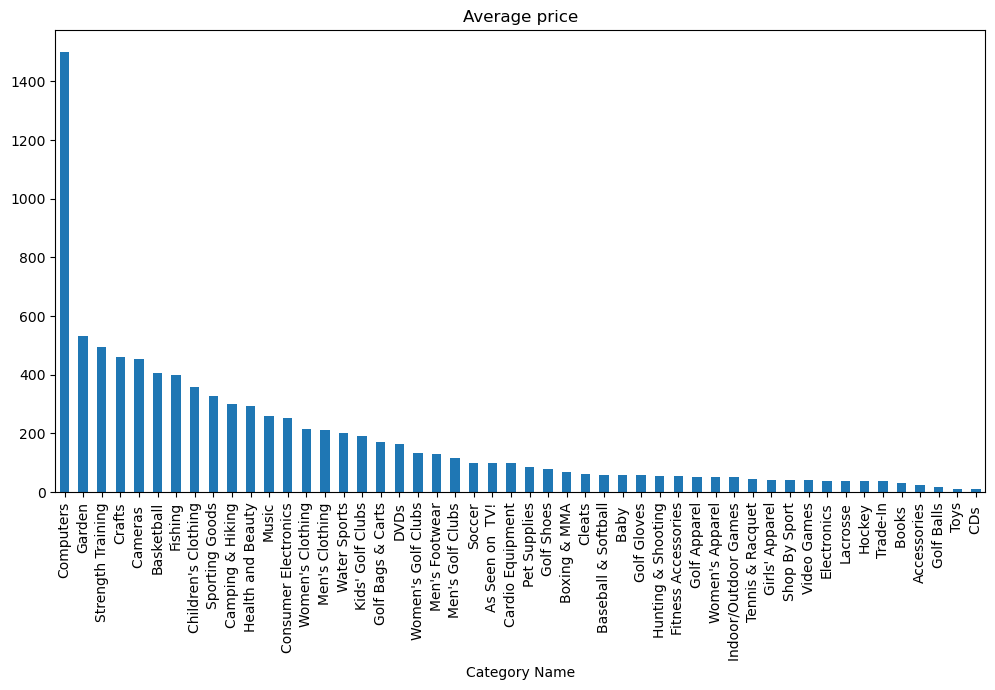

In [10]:
#Grouping all categories
cat = data.groupby('Category Name')
plt.figure(1)
# Total sum of sales for all categories
cat['Sales per customer'].sum().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Total sales")
# Mean sales for all categories
plt.figure(2)
cat['Sales per customer'].mean().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Average sales")
plt.figure(3)
# Mean prices for all categories
cat['Product Price'].mean().sort_values(ascending=False).plot.bar(figsize=(12,6), title="Average price")



As we can see from fig 1 that the fishing category had most number of sales followed by the Cleats.However it is suprising to see that top 7 products with highest price on average are the most sold products on average with computers having almost 1350 sales despite price being 1500$. Since correlation was high between Price and Sales it will be intresting to see how price is impacting the sales for all the products to see the trend.


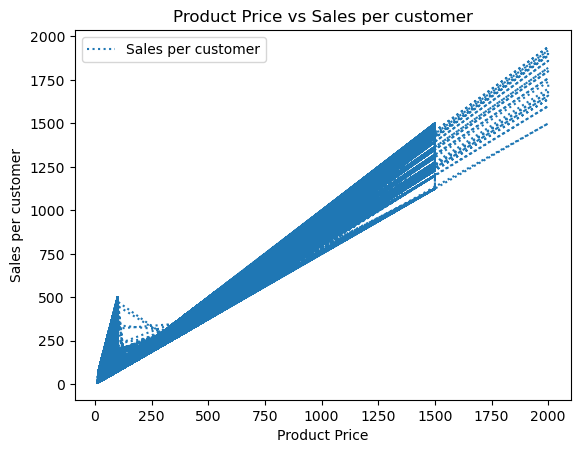

In [11]:
data.plot(x='Product Price', y='Sales per customer',linestyle='dotted',
     markerfacecolor='blue', markersize=12) 
plt.title('Product Price vs Sales per customer')#title
plt.xlabel('Product Price')  # X-axis title
plt.ylabel('Sales per customer') # Y=axis title
plt.show()

 can be observed that prices has linear relation with sales. Which quarter recorded highest sales? It can be found by dividing order time into years,months,week day,hour to better observe the trend.

In [12]:
data['order_year']= pd.DatetimeIndex(data['order date (DateOrders)']).year
data['order_month'] = pd.DatetimeIndex(data['order date (DateOrders)']).month
data['order_week_day'] = pd.DatetimeIndex(data['order date (DateOrders)']).day_name()
data['order_hour'] = pd.DatetimeIndex(data['order date (DateOrders)']).hour
data['order_month_year'] = pd.to_datetime(data['order date (DateOrders)']).dt.to_period('M')

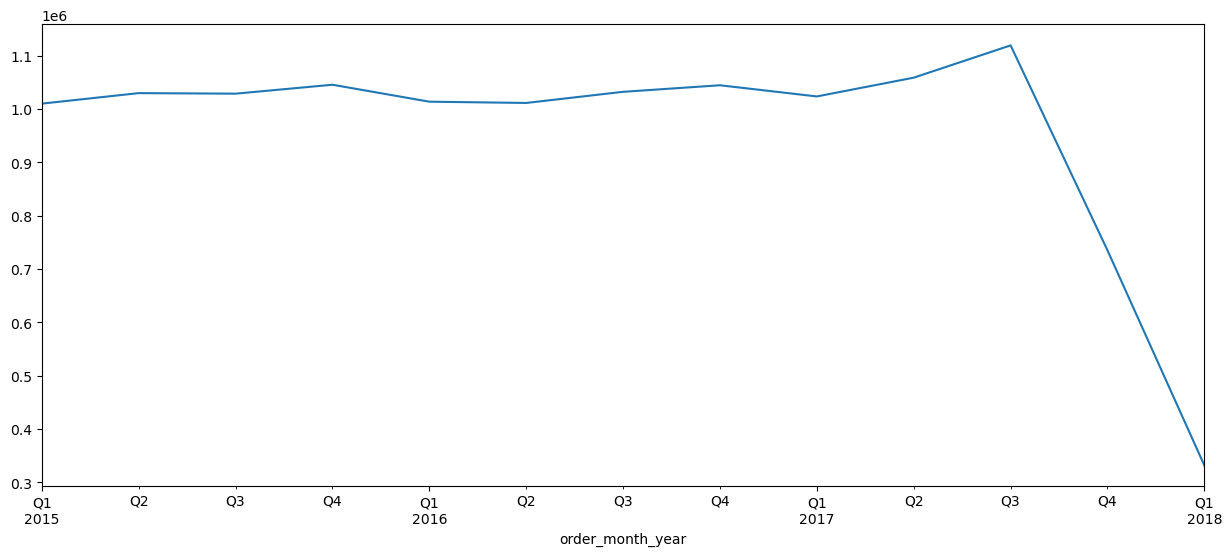

In [13]:
quater= data.groupby('order_month_year')
quartersales=quater['Sales'].sum().resample('Q').mean().plot(figsize=(15,6))

By seeing above graph it can be seen that sales are consistent from Q1 2015 until Q3 of 2017 and suddenly dipped by Q1 2018. What is the purchase trend in week days,hours and months?

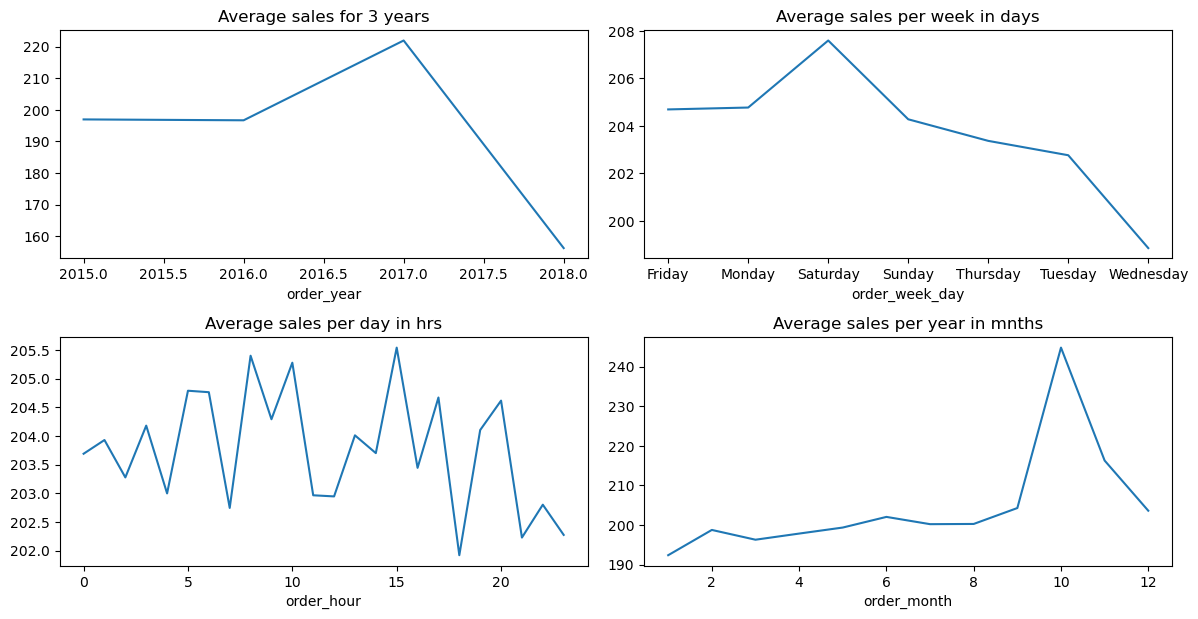

In [14]:
plt.figure(figsize=(10,12))
plt.subplot(4, 2, 1)
quater= data.groupby('order_year')
quater['Sales'].mean().plot(figsize=(12,12),title='Average sales for 3 years')
plt.subplot(4, 2, 2)
days=data.groupby("order_week_day")
days['Sales'].mean().plot(figsize=(12,12),title='Average sales per week in days')
plt.subplot(4, 2, 3)
hrs=data.groupby("order_hour")
hrs['Sales'].mean().plot(figsize=(12,12),title='Average sales per day in hrs')
plt.subplot(4, 2, 4)
mnth=data.groupby("order_month")
mnth['Sales'].mean().plot(figsize=(12,12),title='Average sales per year in mnths')
plt.tight_layout()
plt.show()


How price is impacting sales, when and which products are having more sales are found.The most number of orders came in October followed by November, and orders for all other months are consistent.Highest number of orders are placed by customers in 2017. Saturday recorded highest number of average sales and wednesday with the least number of sales. The average sales are consistent throughout the day irrespective of time with std of 3.

It is also important to know what type of payment method is being preferred by people to buy all these products in all regions? 


In [15]:
data['Type'].unique()

array(['DEBIT', 'TRANSFER', 'CASH', 'PAYMENT'], dtype=object)

Which payment method is preferred the most by people in different regions?

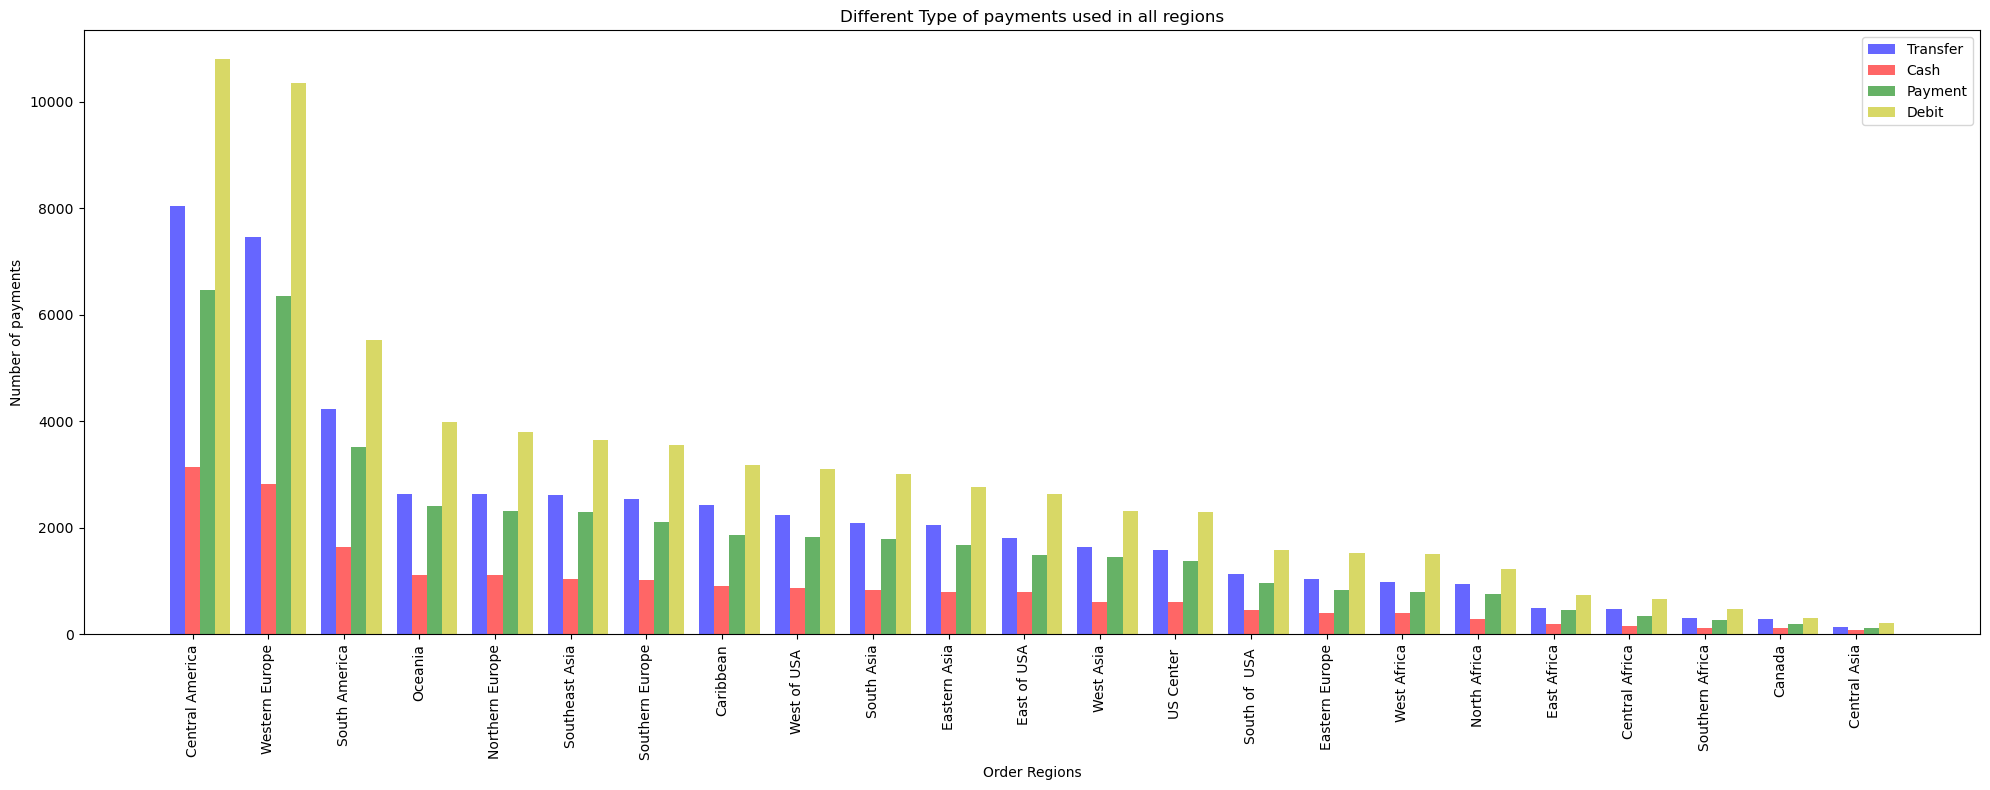

In [16]:
#xyz = data.groupby('Type')
xyz1 = data[(data['Type'] == 'TRANSFER')]
xyz2= data[(data['Type'] == 'CASH')]
xyz3= data[(data['Type'] == 'PAYMENT')]
xyz4= data[(data['Type'] == 'DEBIT')]
count1=xyz1['Order Region'].value_counts()
count2=xyz2['Order Region'].value_counts()
count3=xyz3['Order Region'].value_counts()
count4=xyz4['Order Region'].value_counts()
names=data['Order Region'].value_counts().keys()
n_groups=23
fig,ax = plt.subplots(figsize=(20,8))
index=np.arange(n_groups)
bar_width=0.2
opacity=0.6
type1=plt.bar(index,count1,bar_width,alpha=opacity,color='b',label='Transfer')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='r',label='Cash')
type3=plt.bar(index+bar_width+bar_width,count3,bar_width,alpha=opacity,color='g',label='Payment')
type4=plt.bar(index+bar_width+bar_width+bar_width,count4,bar_width,alpha=opacity,color='y',label='Debit')
plt.xlabel('Order Regions')
plt.ylabel('Number of payments')
plt.title('Different Type of payments used in all regions')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()



Debit type is most preferred payment method by people in all regions, Cash payment being the least preferred method.

Some products are having negative benefit per orders which indicates that the orders are generating loss of revenue to the company. Which products are these?


Total revenue lost with orders -3883547.345768667


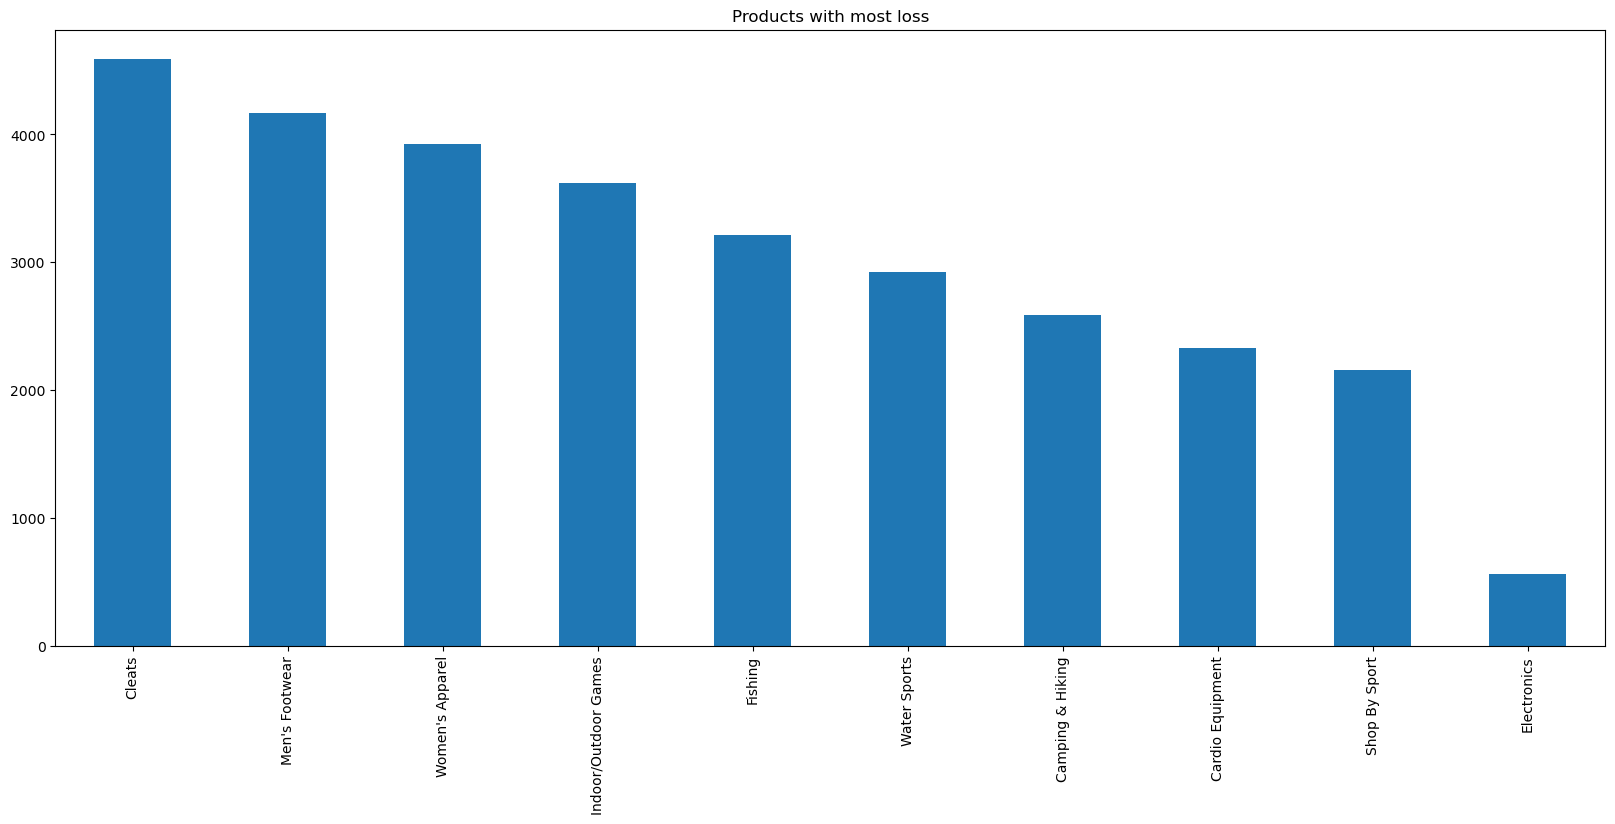

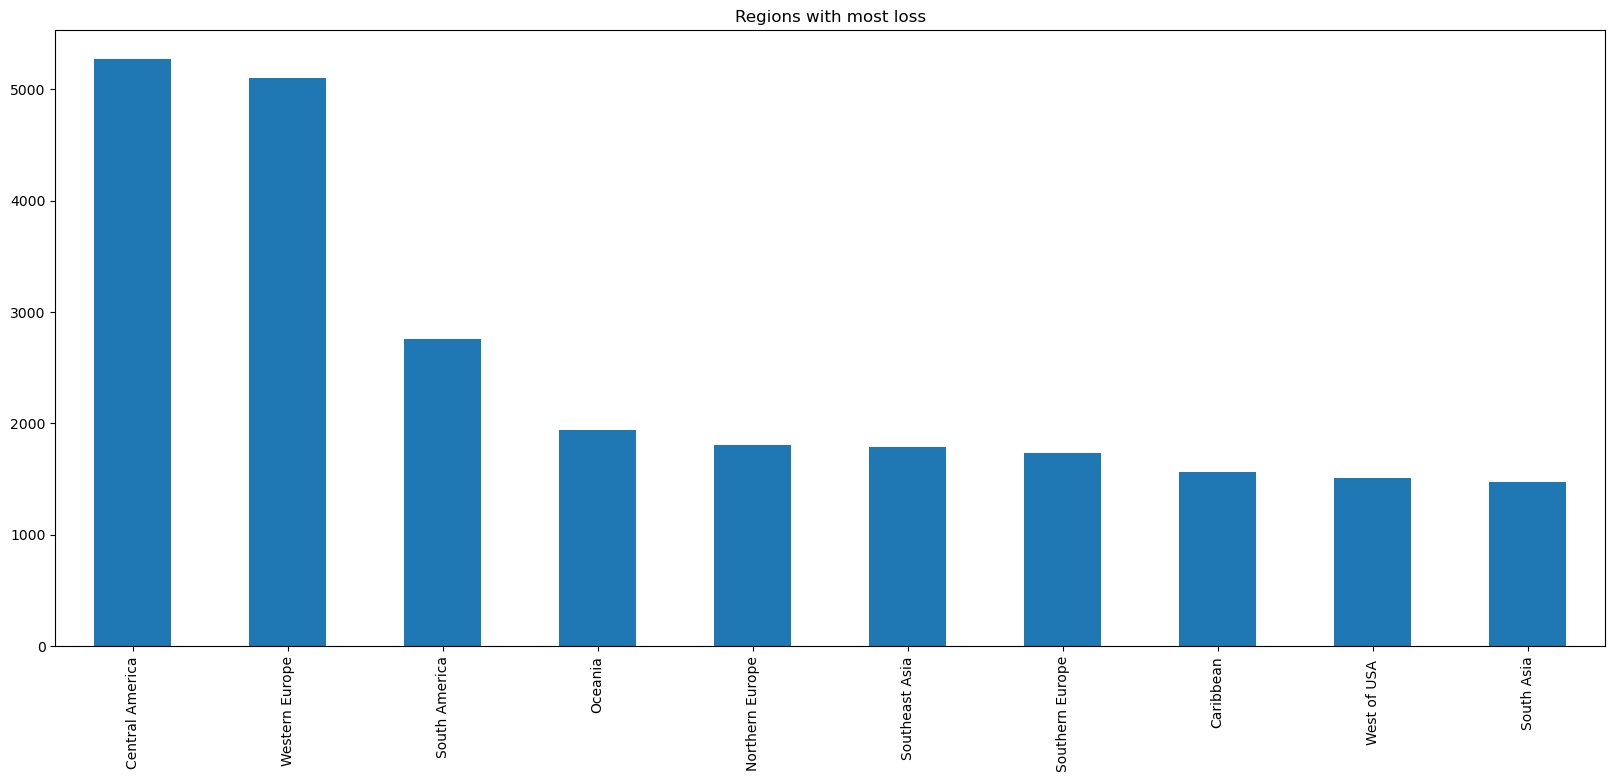

In [17]:
loss = data[(data['Benefit per order']<0)]
#Plotting top 10 products with most loss
plt.figure(1)
loss['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Products with most loss")
plt.figure(2)
loss['Order Region'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Regions with most loss")
#Sum of total sales which are lost
print('Total revenue lost with orders',loss['Benefit per order'].sum())



The total loss sales are approximately 3.9 Millions which is an huge amount.It can be seen that Cleats is the category with most loss sales followed by Mens footwear.Most lost sales are happeing in central america and western europe region.This lost sales may have happened due to suspected frauds or late deliveries.

Finding which payment method is used to conduct frauds can be useful to prevent fraud from happening in future


In [18]:


#Checking type of payment used to conduct fraud other than Transfer
xyz = data[(data['Type'] != 'TRANSFER')&(data['Order Status'] == 'SUSPECTED_FRAUD')]
xyz['Order Region'].value_counts()



Series([], Name: Order Region, dtype: int64)



It can be clearly seen that there are no frauds conducted with DEBIT,CASH,PAYMENT methods so all the suspected fraud orders are made using wire transfer probably from abroad. Which region and what product is being suspected to the fraud the most?


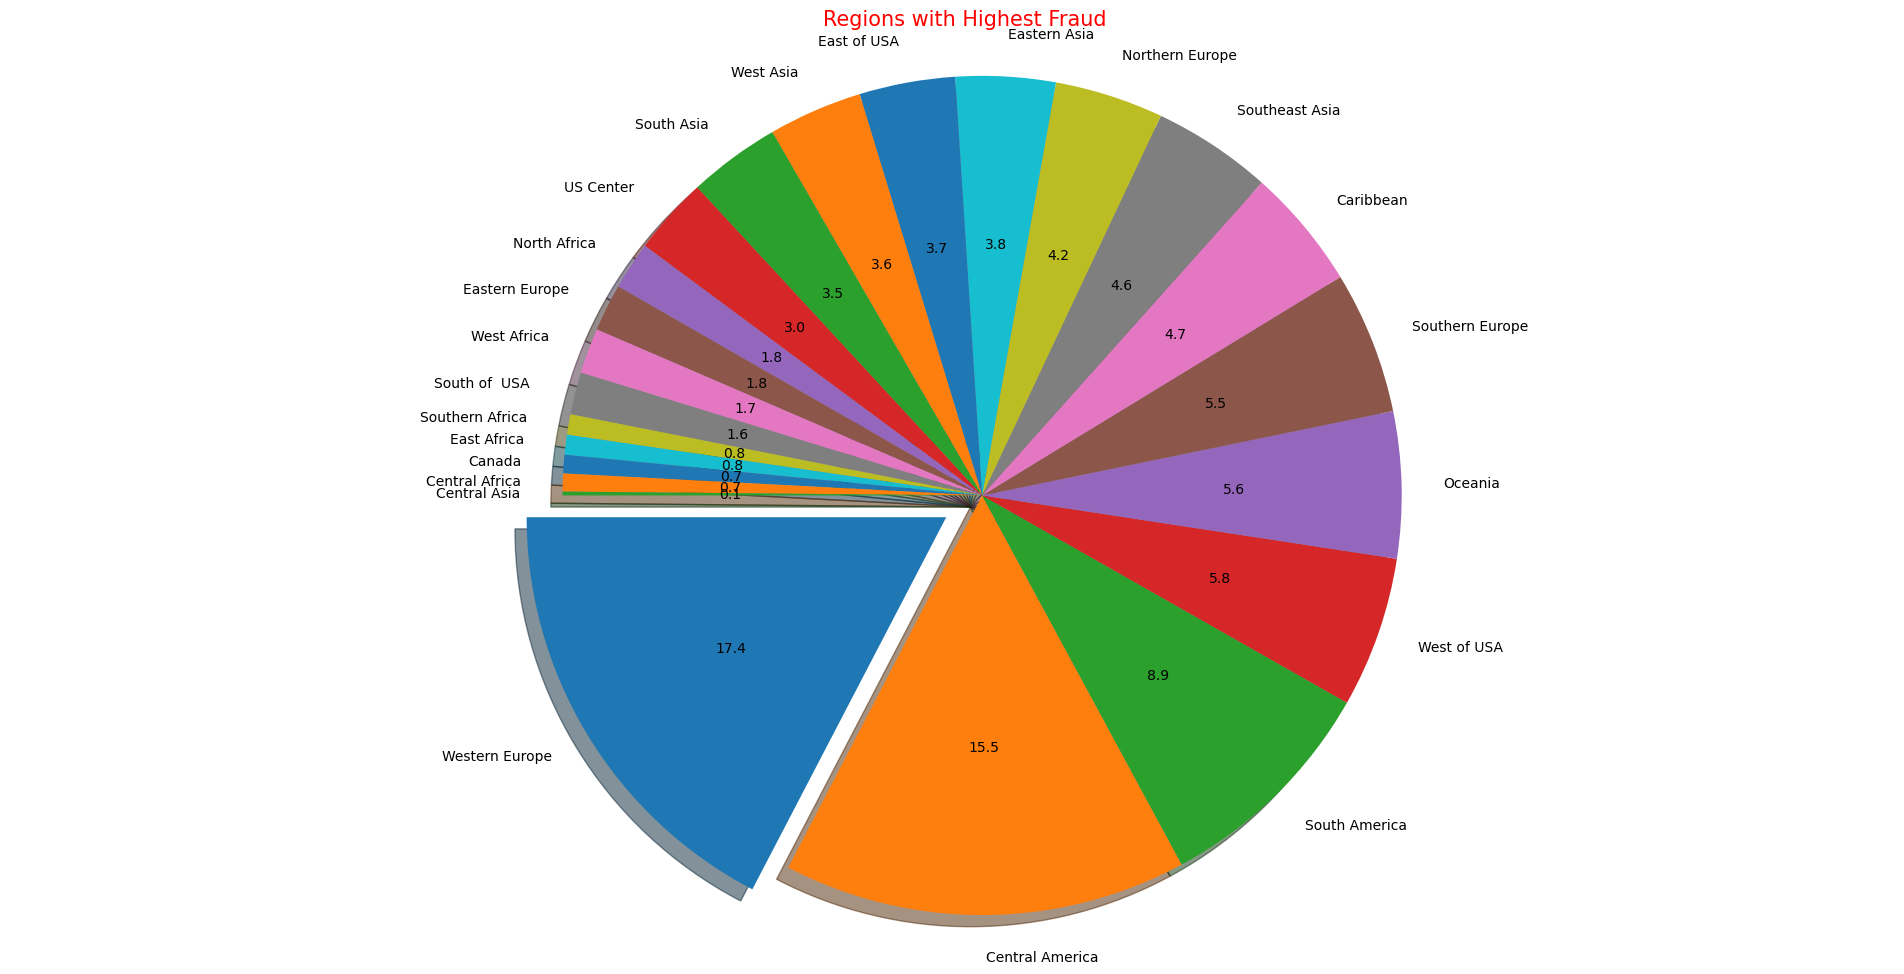

In [19]:
high_fraud = data[(data['Order Status'] == 'SUSPECTED_FRAUD') & (data['Type'] == 'TRANSFER')]#separating orders with suspected fraud
#Plotting pie chart with respect to order region
fraud=high_fraud['Order Region'].value_counts().plot.pie(figsize=(24,12),
                                                  startangle=180, explode=(0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0),autopct='%.1f',shadow=True,)
plt.title("Regions with Highest Fraud",size=15,color='r') # Plotting title
plt.ylabel(" ")
fraud.axis('equal') 
plt.show()



It can be observed that highest number of suspected fraud orders are from Western Europe which is approximately 17.4% of total orders followed by Central America with 15.5%. Which product is being suspected fraud the most?


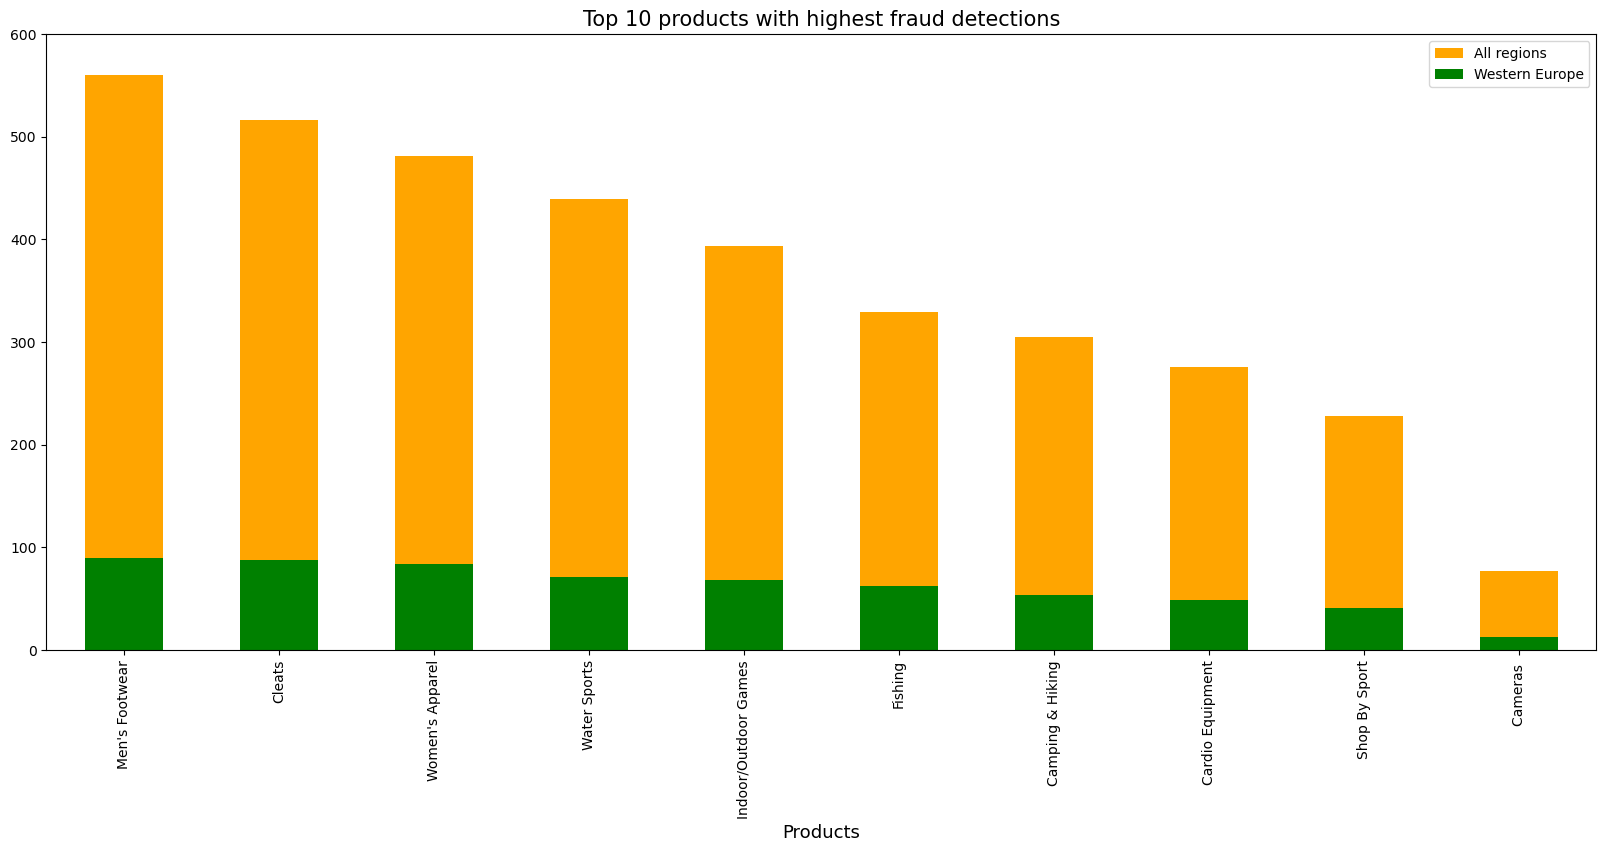

In [20]:
high_fraud1 = data[(data['Order Status'] == 'SUSPECTED_FRAUD')] # 
high_fraud2 = data[(data['Order Status'] == 'SUSPECTED_FRAUD') &(data['Order Region'] == 'Western Europe')]
#Plotting bar chart for top 10 most suspected fraud department in all regions
fraud1=high_fraud1['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Fraud Category",color='orange')
#Plotting bar chart for top 10 most suspected fraud department in Western Europe
fraud2=high_fraud2['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Fraud product in Western Europe",color='green')
plt.legend(["All regions", "Western Europe"])
plt.title("Top 10 products with highest fraud detections", size=15)
plt.xlabel("Products", size=13)
plt.ylim(0,600)
plt.show()

It is very suprising to see that cleats department is being suspected to fraud the most followed by Men's footwear in all the regions and also in Western Europe.Which customers are conducting all these fraud?

<AxesSubplot:title={'center':'Top 10 Highest Fraud Customers'}>

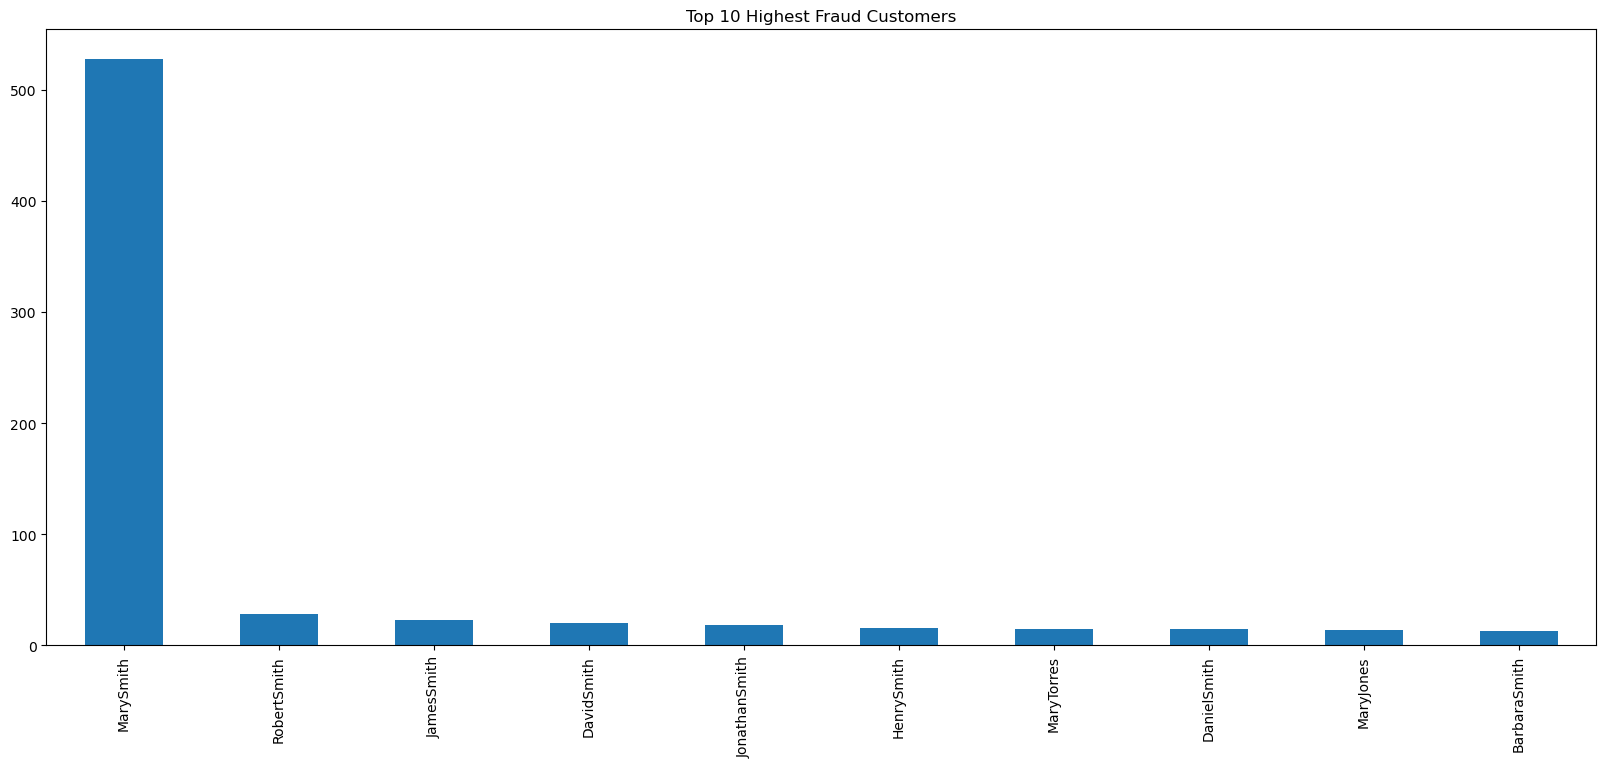

In [21]:


#Filtering out suspected fruad orders
cus = data[(data['Order Status'] == 'SUSPECTED_FRAUD')] 
#Top 10 customers with most fraud
cus['Customer Full Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Top 10 Highest Fraud Customers")



The customer named Mary Smith alone was responible for trying to conduct fraud 528 times which is very shocking .How much amount exactly did she conduct fraud orders?

In [22]:


#Filtering orders of mary smith with suspected fraud
amount = data[(data['Customer Full Name'] == 'MarySmith')&(data['Order Status'] == 'SUSPECTED_FRAUD')]
#Plotting bar chart for top 10 most suspected fraud customers
amount['Sales'].sum()



102491.66191043999

The total amount was almost 102k which is very huge amount.Since Mary was using different address every time when placing orders, a new customer id was issued each time which makes it difficult to identify the customer and ban them. All these parameters should be taken into consideration to improve fraud detection algorithm so fraud can be identified more accurately.

Delivering products to customer on time without late delivery is another important aspect for a supply chain company because customers will not be satisfied if products are not delivered on time. What category of products are being delivered late the most?

<AxesSubplot:title={'center':'Top 10 products with most late deliveries'}>

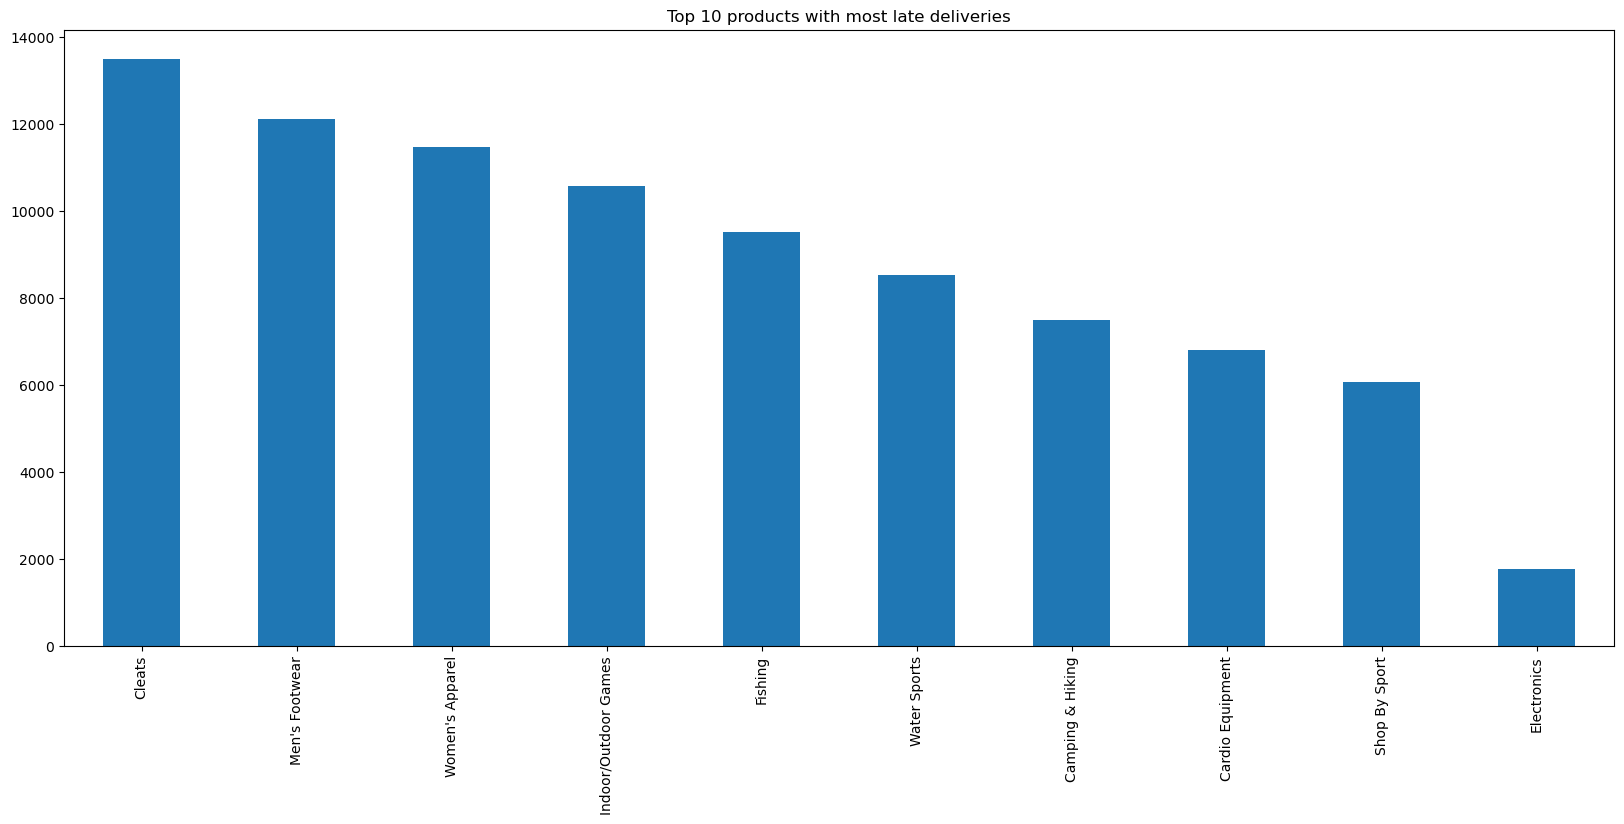

In [23]:
#Filtering columns with late delivery status
late_delivery = data[(data['Delivery Status'] == 'Late delivery')]
#Top 10 products with most late deliveries
late_delivery['Category Name'].value_counts().nlargest(10).plot.bar(figsize=(20,8), title="Top 10 products with most late deliveries")



It can be seen that orders with Cleats department is getting delayed the most followed by Men's Footwear.For some orders risk of late delivery is given in data.The products with late delivery risk are compared with late delivered products.


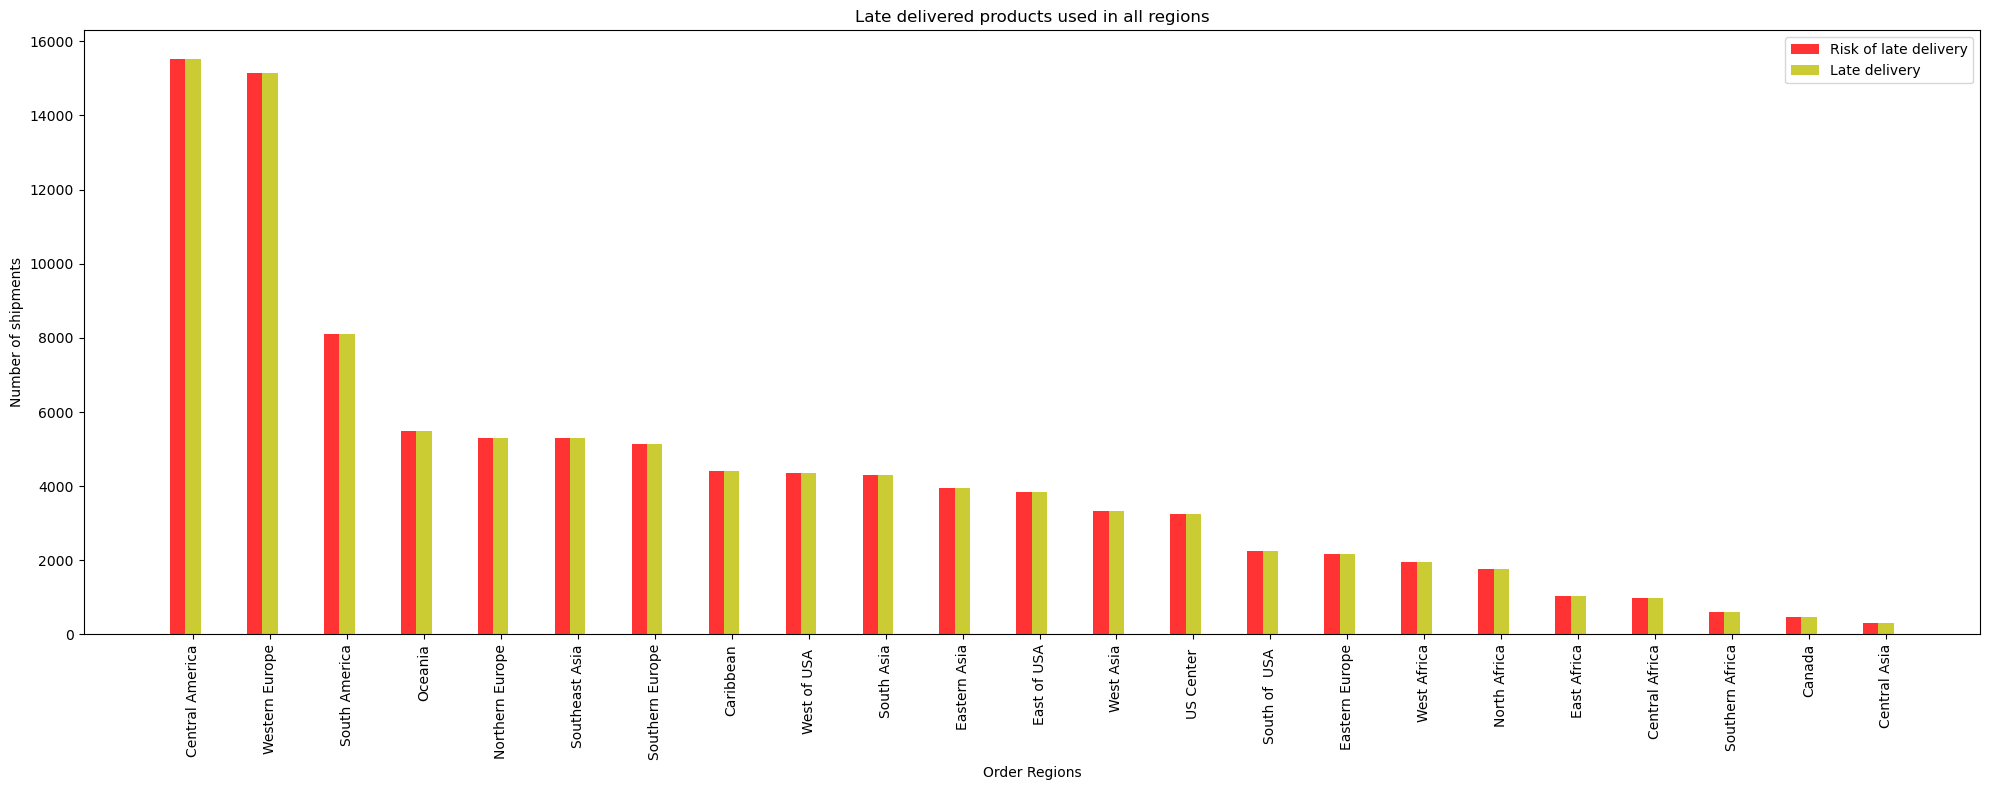

In [24]:
#Filtering orders with late delivery risk
xyz1 = data[(data['Late_delivery_risk'] == 1)]
#Filtering late delivered orders
xyz2 = data[(data['Delivery Status'] == 'Late delivery')]
count1=xyz1['Order Region'].value_counts()
count2=xyz2['Order Region'].value_counts()
#Index names
names=data['Order Region'].value_counts().keys()
n_groups=23
fig,ax = plt.subplots(figsize=(20,8)) #Figure size
index=np.arange(n_groups)
bar_width=0.2
opacity=0.8
type1=plt.bar(index,count1,bar_width,alpha=opacity,color='r',label='Risk of late delivery')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='y',label='Late delivery')
plt.xlabel('Order Regions')
plt.ylabel('Number of shipments')
plt.title('Late delivered products used in all regions')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()



Thus,it can be concluded that for all the products with late delivery risk irrespective of region the product is actually being delivered late,to avoid late delivery the company can ship products faster using better shipping method or schedule more time of Days for shipment so customers will know in advance when the products will reach them. It will be interesting to see the number of late deliveried orders for different types of shipment method in all regions.


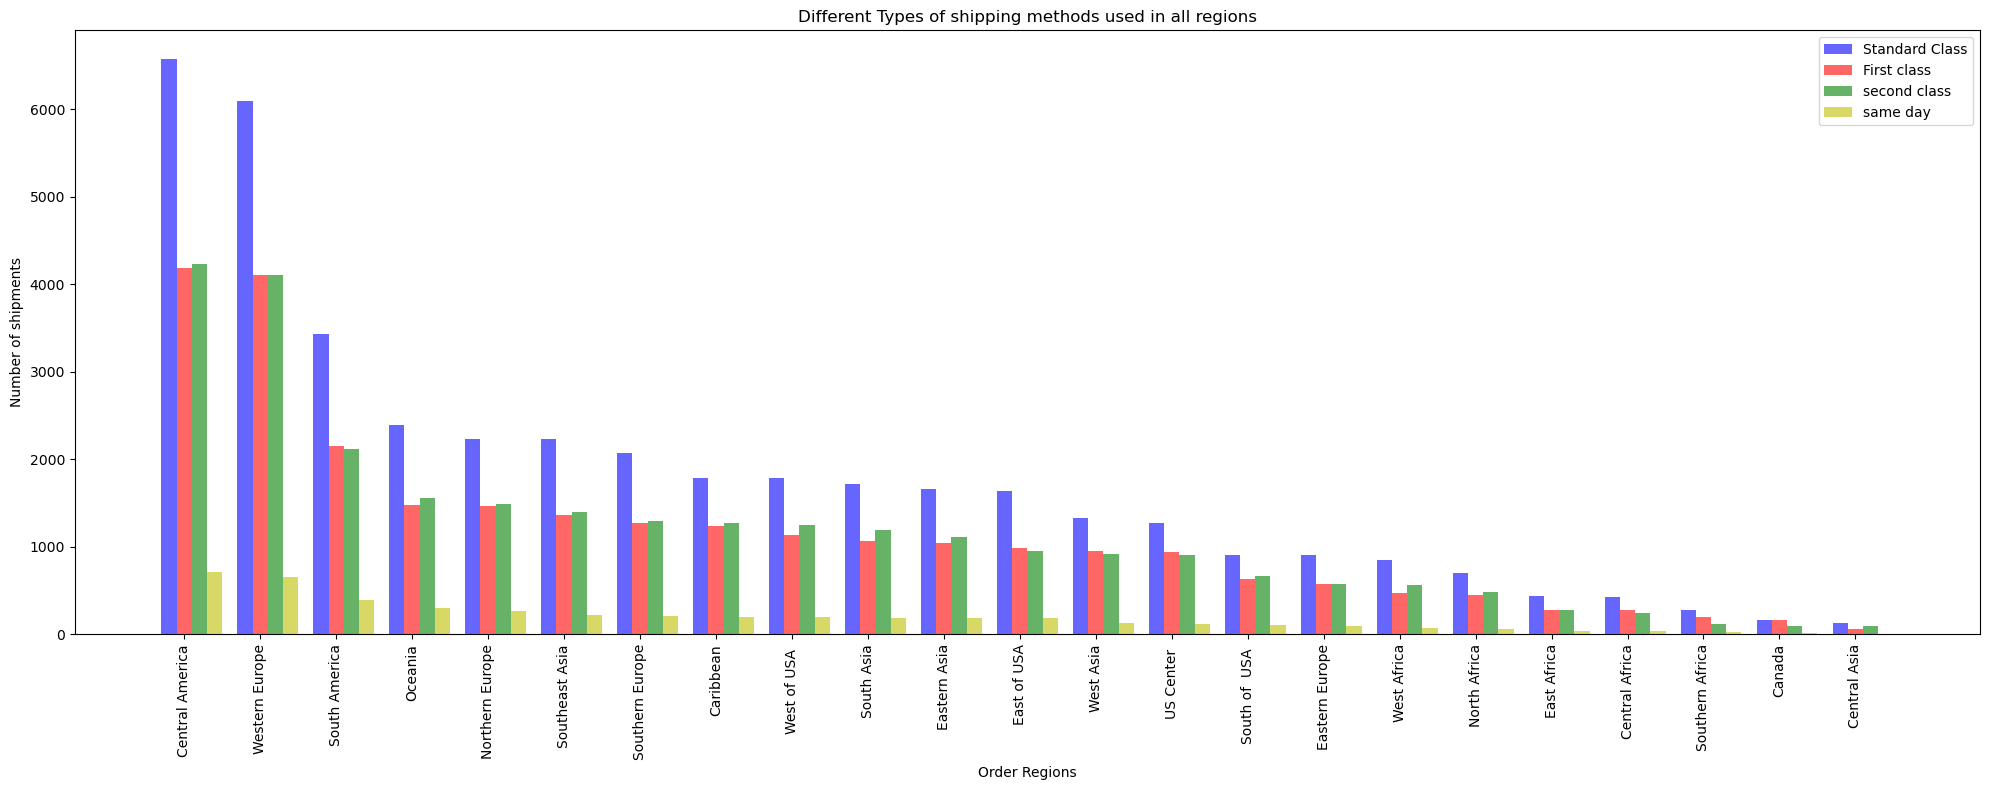

In [25]:
#Filtering late delivery orders with standard class shipping
xyz1 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Standard Class')]
#Filtering late delivery orders with first class shipping
xyz2 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'First Class')]
#Filtering late delivery orders with second class shipping
xyz3 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Second Class')]
#Filtering late delivery orders with same day shipping
xyz4 = data[(data['Delivery Status'] == 'Late delivery') & (data['Shipping Mode'] == 'Same Day')]
#Counting total values
count1=xyz1['Order Region'].value_counts()
count2=xyz2['Order Region'].value_counts()
count3=xyz3['Order Region'].value_counts()
count4=xyz4['Order Region'].value_counts()
#Index names
names=data['Order Region'].value_counts().keys()
n_groups=23
fig,ax = plt.subplots(figsize=(20,8))
index=np.arange(n_groups)
bar_width=0.2
opacity=0.6
type1=plt.bar(index,count1,bar_width,alpha=opacity,color='b',label='Standard Class')
type2=plt.bar(index+bar_width,count2,bar_width,alpha=opacity,color='r',label='First class')
type3=plt.bar(index+bar_width+bar_width,count3,bar_width,alpha=opacity,color='g',label='second class')
type4=plt.bar(index+bar_width+bar_width+bar_width,count4,bar_width,alpha=opacity,color='y',label='same day')
plt.xlabel('Order Regions')
plt.ylabel('Number of shipments')
plt.title('Different Types of shipping methods used in all regions')
plt.legend()
plt.xticks(index+bar_width,names,rotation=90)
plt.tight_layout()
plt.show()

As expected the most number of late deliveries for all regions occured with standard class shipping,with same day shipping being the one with least number of late deliveries.Both the first class and second class shipping have almost equal number of late deliveries.